# Text Mining Project 2022/23, NOVA IMS, MDSAA

# Group 15

## Authors: 
**Adriana Monteiro 20220604\
Mafalda Paço 20220619\
Marta Dinis 20220611\
Patricia Morais 20220638**


## Index<a class="anchor" id="index" />

1 - [Imports</font>](#topic01) <br>
2 - [Functions to handle data](#topic02) <br>
>    2.1 [Preprocess functions](#topic02.01) <br>
    2.2 [Other functions](#topic02.02) <br>

3 - [Import and Preprocess data](#topic03) <br>
4 - [TF-IDF](#topic04) <br>
>   4.1 [TF-IDF without reviews](#topic04.01) <br>
    4.2 [TF-IDF functions](#topic04.02) <br>
    
5 - [GloVe Embeddings](#topic05) <br>
>   5.1 [GloVe without reviews](#topic05.01) <br>
    5.2 [GloVe with reviews](#topic05.02) <br>
    
6 - [FastText Embeddings](#topic06) <br>
>   6.1 [FastText without reviews](#topic06.01) <br>

7 - [Test predictions](#topic07) <br>

<a class="anchor" id="topic01" /><br>
# Step 1: Import of all needed libraries
[Back to Index](#index)

In [ ]:
#!pip install vaderSentiment
#!pip install wordcloud
#!pip install pysentimiento
#!pip install vaderSentiment-fr
#!pip install imbalanced-learn
#!pip install gensim

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim

#from torchtext.legacy.datasets import Multi30k
#from torchtext.legacy.data import Field, BucketIterator

import spacy
from spacy.language import Language
from spacy_language_detection import LanguageDetector

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import string
import re
#!pip install emoji
import emoji
#!pip install contractions
import contractions
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
#!python -m spacy download pt_core_news_sm
# !python -m spacy download fr_core_news_sm
# !python -m spacy download en_core_web_sm

import random
import math
import time

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.neighbors import KNeighborsClassifier

import warnings
warnings.filterwarnings("ignore")

import tqdm
from wordcloud import WordCloud
from wordcloud import ImageColorGenerator
from collections import Counter
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import balanced_accuracy_score, f1_score, recall_score, precision_score, roc_auc_score
from sklearn.metrics import confusion_matrix

from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer as siden
from pysentimiento import create_analyzer
from vaderSentiment_fr.vaderSentiment import SentimentIntensityAnalyzer as sidfr
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import GridSearchCV
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.naive_bayes import GaussianNB
import torchtext.vocab as vocab
import gensim.downloader
from imblearn.ensemble import BalancedRandomForestClassifier
from scipy import sparse

<a class="anchor" id="topic02" /><br>
# Step 2: Define functions to handle data
[Back to Index](#index)

<a class="anchor" id="topic02.01" /><br>
## 2.1 Preprocess functions

### 2.1.1 Remove Html

In [2]:
CLEANR = re.compile('<.*?>|&([a-z0-9]+|#[0-9]{1,6}|#x[0-9a-f]{1,6});')

def cleanhtml(dataframe):
    dataframe_cleaned = dataframe.copy()
    for column in dataframe_cleaned.columns:
        if column in text_columns_reviews+text_columns_airbnb:
            dataframe_cleaned[column] = dataframe_cleaned[column].apply(lambda x: re.sub(CLEANR, ' ', x))
            dataframe_cleaned[column] = dataframe_cleaned[column].str.replace('\n', '')
    
    dataframe_cleaned.reset_index(drop=True, inplace = True)
    return dataframe_cleaned

### 2.1.2 Lowercasing

In [3]:
def lowercasing(dataframe):
    dataframe_lowercased = dataframe.copy()
    for column in dataframe_lowercased.columns:
        if column in text_columns_reviews+text_columns_airbnb:
            dataframe_lowercased[column] = dataframe_lowercased[column].str.lower()
    
    dataframe_lowercased.reset_index(drop=True, inplace = True)

    return dataframe_lowercased

### 2.1.3 Remove punctuation

In [4]:
def remove_punctuation(dataframe):
    dataframe_unpunctuation = dataframe.copy()
    for column in dataframe_unpunctuation.columns:
        if column in text_columns_reviews + text_columns_airbnb:
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].str.replace(f"[{re.escape(string.punctuation)}]", ' ')
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].str.replace(' +', ' ')
            dataframe_unpunctuation[column] = dataframe_unpunctuation[column].apply(lambda x: str(x).encode("ascii", "ignore").decode())
    dataframe_unpunctuation.reset_index(drop=True, inplace = True)
    return dataframe_unpunctuation

### 2.1.4 Remove empty

In [5]:
def remove_empty(dataframe):
    dataframe_noempty = dataframe.copy()
    for column in dataframe_noempty.columns:
        dataframe_noempty[column].replace('', np.nan, inplace=True)
        dataframe_noempty.replace(r'^\s+$', np.nan, regex=True, inplace = True) 
        dataframe_noempty.dropna(subset=[column], inplace=True)
    dataframe_noempty.reset_index(drop=True, inplace = True)
    return dataframe_noempty

### 2.1.5 Remove emojis

In [6]:
def remove_emoji(dataframe, columns):
    dataframe_unemoji = dataframe.copy()
    for column in columns:
        dataframe_unemoji[column] = dataframe_unemoji[column].apply(lambda s: emoji.replace_emoji(s, ''))
    dataframe_unemoji.reset_index(drop=True, inplace = True)
    return dataframe_unemoji

### 2.1.6  Replace emojis

In [7]:
def convert_emoji(dataframe, columns):
    dataframe_reemoji = dataframe.copy()

    for column in columns:
        index= 0
        for row in dataframe_reemoji[column]:
            if dataframe_reemoji[column+"_lang"][index] == "en":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index])
            elif dataframe_reemoji[column+"_lang"][index] == "pt":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index], language='pt')
            elif dataframe_reemoji[column+"_lang"][index] == "fr":
                dataframe_reemoji[column][index] = emoji.demojize(dataframe_reemoji[column][index], language='fr')
            else:
                dataframe_reemoji[column][index] = emoji.replace_emoji(dataframe_reemoji[column][index], '')
            index+=1
    dataframe_reemoji.reset_index(drop=True, inplace = True)
    return dataframe_reemoji

### 2.1.7  Expand contractions

In [8]:
def expand_contractions(dataframe):
    dataframe_contractions = dataframe.copy()
    
    def remove_cont(text):
        expanded_words = []   
        for word in text.split():
            expanded_words.append(contractions.fix(word)) 
        return ' '.join(expanded_words)
        
    for column in dataframe_contractions.columns:
        if column in text_columns_reviews + text_columns_airbnb:
            dataframe_contractions[column] = dataframe_contractions[column].apply(remove_cont)
            dataframe_contractions[column] = dataframe_contractions[column].str.replace('’s', '')
    dataframe_contractions.reset_index(drop=True, inplace = True)
    return dataframe_contractions

### 2.1.8  Remove patterns of digits

In [9]:
def remove_digits(dataframe, columns):
    dataframe_digits = dataframe.copy()
    for column in columns:
        dataframe_digits[column] = dataframe_digits[column].apply(lambda x: x.replace("x000d ", ""))
        dataframe_digits[column] = dataframe_digits[column].apply(lambda x: re.sub(r'\d+', '', x))
    dataframe_digits.reset_index(drop=True, inplace = True)
    return dataframe_digits

### 2.1.9  Removing stopwords

In [10]:
def remove_stopwords(dataframe, columns):
    dataframe_stop= dataframe.copy()
    stopwords_pt = nltk.corpus.stopwords.words('portuguese')
    stopwords_en = nltk.corpus.stopwords.words('english')
    stopwords_fr = nltk.corpus.stopwords.words('french')
    for column in columns:
        counter= 0
        for row in dataframe_stop[column]:
            if dataframe_stop[column+"_lang"][counter] == "en":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_en])  
            elif dataframe_stop[column+"_lang"][counter] == "pt":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_pt])
            elif dataframe_stop[column+"_lang"][counter] == "fr":
                dataframe_stop[column][counter] = " ".join([word for word in str(row).split() if word not in stopwords_fr])
            else:
                dataframe_stop[column][counter] = dataframe_stop[column][counter]
            counter+=1
    
    dataframe_stop.reset_index(drop=True, inplace = True)

    return dataframe_stop

### 2.1.10  Tokenization

In [11]:
def tokenize(dataframe, columns):
    indexes = dataframe.index.tolist()
    dataframe_token= dataframe.copy()
    for column in columns:
        counter= 0
        for row in dataframe_token[column]:
            if dataframe_token[column+"_lang"][indexes[counter]] == "en":
                dataframe_token[column][indexes[counter]] = word_tokenize(row, language='english')     
            elif dataframe_token[column+"_lang"][indexes[counter]] == "pt":
                dataframe_token[column][indexes[counter]] = word_tokenize(row, language='portuguese') 
            elif dataframe_token[column+"_lang"][indexes[counter]] == "fr":
                dataframe_token[column][indexes[counter]] = word_tokenize(row, language='french') 
            else:
                dataframe_token[column][indexes[counter]] = row.split()
            counter+=1
    
    return dataframe_token

### 2.1.11  Lemmatization

In [12]:
def lemmatize(dataframe, columns):
    dataframe_lemmas = dataframe.copy()
    
    nlp_en = spacy.load("en_core_web_sm")
    nlp_pt = spacy.load("pt_core_news_sm")
    nlp_fr = spacy.load("fr_core_news_sm")
    nlp_fr = spacy.load("fr_core_news_sm")
    
    for column in columns:
        counter = 0
        
        for row in dataframe_lemmas[column]:
            if dataframe_lemmas[column+"_lang"][counter] == "en":
                doc = nlp_en(row)
                dataframe_lemmas[column][counter] = ' '.join([token.lemma_ for token in doc])  
            elif dataframe_lemmas[column+"_lang"][counter] == "pt":
                doc = nlp_pt(row)
                dataframe_lemmas[column][counter] =  ' '.join([token.lemma_ for token in doc])
            elif dataframe_lemmas[column+"_lang"][counter] == "fr":
                doc = nlp_fr(row)
                dataframe_lemmas[column][counter] =  ' '.join([token.lemma_ for token in doc])
            else:
                dataframe_lemmas[column][counter] = dataframe_lemmas[column][counter]
            counter += 1
    dataframe_lemmas.reset_index(drop=True, inplace = True)

    return dataframe_lemmas

### 2.1.12  Detect Language

In [13]:
#!python -m spacy download en_core_web_sm
def get_lang_detector(nlp, name):
    return LanguageDetector(seed=42)  # We use the seed 42

nlp_model = spacy.load("en_core_web_sm")
Language.factory("language_detector", func=get_lang_detector)
nlp_model.add_pipe('language_detector', last=True)

In [14]:
def detect_language(dataframe, columns):
    dataframe_lang = dataframe.copy()
    
    def dl(text):
        doc = nlp_model(text)
        lang = None
        for sent in doc.sents:
            lang = sent._.language['language']
        return lang  # Return the language for the first sentence
    
    for column in columns:
        dataframe_lang[column+'_lang'] = dataframe_lang[column].apply(dl)
    
    dataframe_lang.reset_index(drop=True, inplace = True)
    
    return dataframe_lang

<a class="anchor" id="topic02.02" /><br>
## 2.2 Other functions

### 2.2.1 Sentiment Analysis

In [15]:
def sentiment_reviews(df, columns):
    
    dataframe_sentiment = df.copy()
    analyser_pt = create_analyzer(task="sentiment", lang="pt")
    sid_en = siden()
    sid_fr = sidfr()
    sentiment = []

    for column in columns:
        counter = 0
        total_rows = len(dataframe_sentiment[column])

        for row in tqdm.tqdm(dataframe_sentiment[column], total=total_rows, desc=f"Sentiment Analysis of {column}"):

            if dataframe_sentiment[column+"_lang"][counter] == "en":
                score = sid_en.polarity_scores(dataframe_sentiment[column][counter])['compound']
                if score >= 0.05:
                    sentiment.append(1)
                elif score <= -0.05:
                    sentiment.append(-1)
                elif -0.05 < score < 0.05:
                    sentiment.append(0)
                
   
            elif dataframe_sentiment[column+"_lang"][counter] == "pt":
                score = analyser_pt.predict(dataframe_sentiment[column][counter]).output
                if score == 'POS':
                    sentiment.append(1)
                elif score == 'NEG':
                    sentiment.append(-1)
                elif score == 'NEU':
                    sentiment.append(0)
            

            elif dataframe_sentiment[column+"_lang"][counter] == "fr":
                score = sid_fr.polarity_scores(dataframe_sentiment[column][counter])['compound']
                if score >= 0.05:
                    sentiment.append(1)
                elif score <= -0.05:
                    sentiment.append(-1)
                elif -0.05 < score < 0.05:
                    sentiment.append(0)
            
            else:
                sentiment.append(0)
            
            counter += 1

    dataframe_sentiment['sentiment'] = sentiment
    
    return dataframe_sentiment

### 2.2.2 Pipeline to clean data

In [16]:
def pipelinefunc(data, columns, html=True, lowercase=True, puntuation=True, empty=False, removeemoji=True, conv_emoji=True,
                 detectlanguage=True, filterlang = False, contraction=True, digits=True, stopwords=True, tokenize=True, Lemmatize=True):

    data_pipe=data.copy()
    if html:
        data_pipe = cleanhtml(data_pipe)
        print('html done')
    if lowercase:
        data_pipe = lowercasing(data_pipe)
        print('lowercase done')
    if contraction:
        data_pipe = expand_contractions(data_pipe)
        print('contraction done')
    if puntuation:
        data_pipe = remove_punctuation(data_pipe)
        print('punctuation done')
    if empty:
        data_pipe = remove_empty(data_pipe)
        print('empty done')
    if removeemoji:
        data_pipe = remove_emoji(data_pipe, columns) #['description','host_about']
        print('remove_emoji done')
    if detectlanguage:
        data_pipe = detect_language(data_pipe, columns) #['description','host_about'] or ['comments']
        print('detect_language done')
    if filterlang:
        data_pipe = filter_lang(data_pipe, columns)
        print('filter lang done')
    if conv_emoji:
        data_pipe = convert_emoji(data_pipe, columns) #['comments']
        print('conv_emoji done')
        data_pipe = remove_punctuation(data_pipe)
        print('punctuation 2 done')
    if digits:
        data_pipe = remove_digits(data_pipe, columns) #['host_about', 'description'] or ['comments']
        print('digits done')
    if stopwords:
        data_pipe = remove_stopwords(data_pipe, columns) #['host_about', 'description'] or ['comments']
        print('stopwords done')
    if Lemmatize:
        data_pipe = lemmatize(data_pipe, columns) #['host_about', 'description'] or ['comments']
        print('lematize done')

    return data_pipe

### 2.2.3 Confusion matrix plot

In [17]:
def plot_cm(confusion_matrix : np.array, 
            classnames : list):
    """
    Function that creates a confusion matrix plot using the Wikipedia convention for the axis. 
    :param confusion_matrix: confusion matrix that will be plotted
    :param classnames: labels of the classes
    
    Returns:
        - Plot of the Confusion Matrix
    """
    
    confusionmatrix = confusion_matrix
    class_names = classnames             

    fig, ax = plt.subplots()
    im = plt.imshow(confusionmatrix, cmap=plt.cm.cividis)
    plt.colorbar()

    # We want to show all ticks...
    ax.set_xticks(np.arange(len(class_names)))
    ax.set_yticks(np.arange(len(class_names)))
    # ... and label them with the respective list entries
    ax.set_xticklabels(class_names)
    ax.set_yticklabels(class_names)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for i in range(len(class_names)):
        for j in range(len(class_names)):
            text = ax.text(j, i, confusionmatrix[i, j],

                           ha="center", va="center", color="w")
    plt.xlabel('Targets')
    plt.ylabel('Predictions')
    plt.ylim(top=len(class_names)-0.5)  # adjust the top leaving bottom unchanged
    plt.ylim(bottom=-0.5)  # adjust the bottom leaving top unchanged
    return plt.show()

### 2.2.4 Results

In [18]:
def apply_model (X_train, y_train, X_val, y_val ,model, metrics = None, plot_confusion_matrix = False, class_report = False, vprint=False):

    model_fitted = model.fit(X_train, y_train)
    y_train_pred = model_fitted.predict(X_train)
    y_val_pred = model_fitted.predict(X_val)

    model_scores_train = []
    model_scores_val = []
    df = pd.DataFrame()
    
    if plot_confusion_matrix == True:
        print('Training confusion matrix:')
        plot_cm(confusion_matrix(y_train, y_train_pred), ['Listed', 'Unlisted'])
        print('\n\n Validation confusion matrix:')
        plot_cm(confusion_matrix(y_val, y_val_pred),  ['Listed', 'Unlisted'])

    if class_report == True:
        print('\n-------------------------------------------------------------\n')
        print('Training classification report:')
        print(classification_report(y_train, y_train_pred))
        print('\n\nValidation classification report:')
        print(classification_report(y_val, y_val_pred))
        
    if metrics == None:
        print('\n-------------------------------------------------------------\n')
        print('You chose to not output any metrics. Yout options are: ["balanced_accuracy", "f1", "recall", "precision", "roc_auc"]')

    else:
        if vprint:
            print('\n-------------------------------------------------------------\n')
            print('The full options are: ["balanced_accuracy", "f1", "recall", "precision", "roc_auc"]')
            print('You chose:', metrics, )
        for metric in metrics:
            if metric == 'balanced_accuracy':
                model_scores_train.append(balanced_accuracy_score(y_train, y_train_pred))
                model_scores_val.append(balanced_accuracy_score(y_val, y_val_pred))
            if metric == 'f1':
                model_scores_train.append(f1_score(y_train, y_train_pred))
                model_scores_val.append(f1_score(y_val, y_val_pred))
            if metric == 'recall':
                model_scores_train.append(recall_score(y_train, y_train_pred))
                model_scores_val.append(recall_score(y_val, y_val_pred))
            if metric == 'precision':
                model_scores_train.append(precision_score(y_train, y_train_pred))
                model_scores_val.append(precision_score(y_val, y_val_pred))
            if metric == 'roc_auc':
                model_scores_train.append(roc_auc_score(y_train, y_train_pred))
                model_scores_val.append(roc_auc_score(y_val, y_val_pred))
    
    df['train'] = model_scores_train
    df['val'] = model_scores_val
    df['metric'] = metrics
    df.set_index('metric', inplace = True)
    return df


<a class="anchor" id="topic03" /><br>
# Step 3:Import and Preprocess data
[Back to Index](#index)

### Importing data

In [19]:
# Import data
airbnb_df_train = pd.read_excel('../data/train.xlsx')
reviews_df_train = pd.read_excel('../data/train_reviews.xlsx')

airbnb_df_test = pd.read_excel('../data/test.xlsx')
reviews_df_test = pd.read_excel('../data/test_reviews.xlsx')

# Set text columns
text_columns_airbnb = ["description","host_about"]
text_columns_reviews = ["comments"]

# Set text columns as strings
airbnb_df_train = airbnb_df_train.astype({'description':'string', 'host_about':'string'})
reviews_df_train = reviews_df_train.astype({'comments':'string'})


In [20]:
reviews_sent = reviews_df_train.groupby(['index'])['comments'].apply(' '.join)
raw_data = airbnb_df_train.join(reviews_sent)
raw_data['comments'] = raw_data['comments'].fillna('')

### Train Validation Split

In [ ]:
X_airbnb_train, X_airbnb_val, y_airbnb_train, y_airbnb_val = train_test_split(airbnb_df_train.drop(['unlisted'], axis=1),
                                                                              airbnb_df_train['unlisted'],
                                                                              test_size=0.2, 
                                                                              train_size=0.8,
                                                                              random_state=42,
                                                                              shuffle=True,
                                                                              stratify=airbnb_df_train['unlisted'])

In [ ]:
len(X_airbnb_train), len(X_airbnb_val), len(y_airbnb_train), len(y_airbnb_val)

### Applying the preprocessing pipeline

Apply the preprocess pipeline to the airbnb train and val data

In [ ]:
# Airbnb Train
X_airbnb_train_clean = pipelinefunc(X_airbnb_train,
             columns = text_columns_airbnb,
             conv_emoji=False
             )
X_airbnb_train_clean.fillna('', inplace=True)

# Airbnb Validation
X_airbnb_val_clean =  pipelinefunc(X_airbnb_val,
             columns = text_columns_airbnb,
             conv_emoji=False
             )
X_airbnb_val_clean.fillna('', inplace=True)

In [ ]:
X_airbnb_train_clean.set_index('index', inplace=True)
X_airbnb_val_clean.set_index('index', inplace=True)

Create the train and val reviews datasets accordingly to the airbnb's indexes in train and val in the airbnb data

In [ ]:
X_reviews_train = reviews_df_train[reviews_df_train['index'].isin(X_airbnb_train.index)]
X_reviews_train.reset_index(drop=True, inplace=True)
X_reviews_val = reviews_df_train[reviews_df_train['index'].isin(X_airbnb_val.index)]
X_reviews_val.reset_index(drop=True, inplace=True)
X_reviews_val

Apply the preprocess pipeline to the reviews train and val data

In [ ]:
X_reviews_train_clean =  pipelinefunc(X_reviews_train,
             columns = text_columns_reviews,
             removeemoji=False
             )
X_reviews_train_clean.fillna('', inplace=True)

X_reviews_val_clean =  pipelinefunc(X_reviews_val,
             columns = text_columns_reviews,
             removeemoji=False
             )
X_reviews_val_clean.fillna('', inplace=True)

Create the sentiment for the reviews train and test data

In [ ]:
X_reviews_train_clean['comments'] = X_reviews_train_clean['comments'].astype('str')
X_reviews_val_clean['comments'] = X_reviews_val_clean['comments'].astype('str')

reviews_sentiment_train = sentiment_reviews(X_reviews_train_clean,columns=text_columns_reviews)
reviews_sentiment_val = sentiment_reviews(X_reviews_val_clean,columns=text_columns_reviews)

Group the sentiment by airbnb and performing an average of it

In [30]:
reviews_sentiment_train_byIndex = reviews_sentiment_train.groupby('index', as_index=True)['sentiment'].mean()
reviews_sentiment_val_byIndex = reviews_sentiment_val.groupby('index', as_index=True)['sentiment'].mean()

In [31]:
X_airbnb_train_clean_sent = X_airbnb_train_clean.join(reviews_sentiment_train_byIndex.rename('sentiment'))
X_airbnb_train_clean_sent['sentiment'] = X_airbnb_train_clean_sent['sentiment'].fillna(0)

X_airbnb_val_clean_sent = X_airbnb_val_clean.join(reviews_sentiment_val_byIndex.rename('sentiment'))
X_airbnb_val_clean_sent['sentiment'] = X_airbnb_val_clean_sent['sentiment'].fillna(0)
X_airbnb_val_clean_sent

,index,description,host_about,description_lang,host_about_lang,sentiment
0,4769,charming apartment first floor typical cascais...,easygoing person always ready present good por...,en,en,0.0
1,4385,charming villa private pool tennis table withi...,allure villas go spot rent villas apartment to...,en,en,0.0
2,11858,one bedroom apartment inside modern developmen...,hey goncalo miku host lisbon start holiday ren...,en,en,0.0
3,1282,apartment heart city prncipe real chiado bairr...,hi laura yo live partner sara two adorable boy...,en,en,0.0
4,2134,amazing flat two bedroom restauradore lisbon s...,feel like home holiday rental company bear uni...,en,en,0.0
...,...,...,...,...,...,...
2495,2649,set stunning seaside location luxury property ...,go someplace new always exciting would adventu...,en,en,0.0
2496,9003,the apartment in lisbon has bedrooms and has ...,feel like home holiday rental company bear uni...,tl,en,0.0
2497,8679,junto palcio s Bento assembleia republicar ant...,old joo vosse espera mostrar Lisboa bom,pt,pt,0.0
2498,5771,apartment homely think detail feel home away h...,hi mojo team mcpp investment management manage...,en,en,0.0


<a class="anchor" id="topic04" /><br>
# Step 4: TF-IDF
[Back to Index](#index)

<a class="anchor" id="topic04.01" /><br>
## 4.1 TF-IDF without reviews

## Tests with different models

In [80]:
def tf_idf(model, class_report=True, plot_confusion_matrix=True):
    transformer = FeatureUnion([
                    ('host_about_tfidf', 
                      Pipeline([('extract_field',
                                  FunctionTransformer(lambda x: x['host_about'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
                    ('description_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['description'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())]))]) 

    tfidf_airbnb_train = transformer.fit_transform(X_airbnb_train_clean)
    tfidf_airbnb_val = transformer.transform(X_airbnb_val_clean)
    if isinstance(model, GaussianNB):
        df = apply_model(X_train=tfidf_airbnb_train.toarray(),y_train=y_airbnb_train, X_val=tfidf_airbnb_val.toarray(), y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    else:
        df = apply_model(X_train=tfidf_airbnb_train,y_train=y_airbnb_train, X_val=tfidf_airbnb_val, y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    return df

### KNN

In [25]:
modelknn = KNeighborsClassifier(n_neighbors = 5, metric = 'cosine', weights = 'distance')

Training confusion matrix:


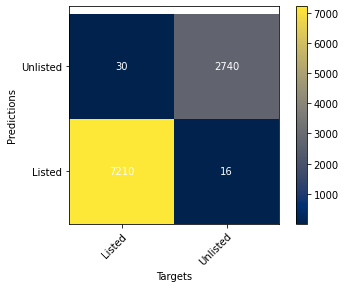



 Validation confusion matrix:


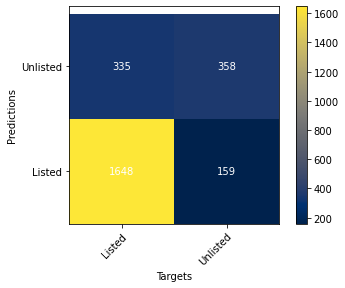


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       0.99      0.99      0.99      2770

    accuracy                           1.00      9996
   macro avg       1.00      0.99      0.99      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.91      0.87      1807
           1       0.69      0.52      0.59       693

    accuracy                           0.80      2500
   macro avg       0.76      0.71      0.73      2500
weighted avg       0.79      0.80      0.79      2500



,train,val
metric,,
balanced_accuracy,0.993478,0.714302
precision,0.994194,0.692456
recall,0.989170,0.516595
f1,0.991676,0.591736
roc_auc,0.993478,0.714302


In [84]:
tf_idf(modelknn)

### Multi Layer Perceptron

In [89]:
mlp_55 = MLPClassifier(hidden_layer_sizes=(10,5), activation='relu', solver='sgd', learning_rate_init=0.01)

Training confusion matrix:


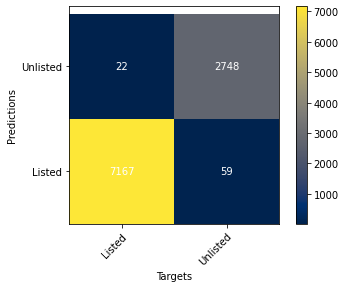



 Validation confusion matrix:


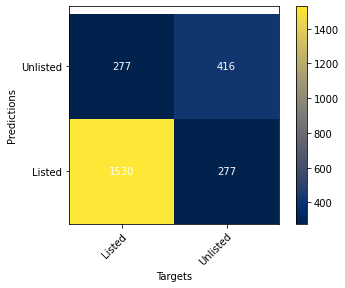


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      7226
           1       0.98      0.99      0.99      2770

    accuracy                           0.99      9996
   macro avg       0.99      0.99      0.99      9996
weighted avg       0.99      0.99      0.99      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.85      0.85      0.85      1807
           1       0.60      0.60      0.60       693

    accuracy                           0.78      2500
   macro avg       0.72      0.72      0.72      2500
weighted avg       0.78      0.78      0.78      2500



,train,val
metric,,
balanced_accuracy,0.991946,0.723498
precision,0.978981,0.600289
recall,0.992058,0.600289
f1,0.985476,0.600289
roc_auc,0.991946,0.723498


In [90]:
tf_idf(mlp_55)

### Grid Search

In [153]:
mlp = MLPClassifier()

In [154]:
parameter_space = {
    'hidden_layer_sizes': [(10,10), (5,5,5)],
    'activation': ['relu'],
    'solver': ['sgd', 'adam'],
    'learning_rate_init': [0.001, 0.01]
}

In [155]:
clf = GridSearchCV(estimator =mlp ,param_grid = parameter_space,verbose=1, scoring='f1',cv=3)

In [156]:
transformer = FeatureUnion([
                    ('host_about_tfidf', 
                      Pipeline([('extract_field',
                                  FunctionTransformer(lambda x: x['host_about'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
                    ('description_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['description'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())]))]) 
tfidf_matrix_train = transformer.fit_transform(X_airbnb_train_clean)

In [157]:
clf.fit(tfidf_matrix_train, y_airbnb_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


GridSearchCV(cv=3, estimator=MLPClassifier(),
             param_grid={'activation': ['relu'],
                         'hidden_layer_sizes': [(10, 10), (5, 5, 5)],
                         'learning_rate_init': [0.001, 0.01],
                         'solver': ['sgd', 'adam']},
             scoring='f1', verbose=1)

In [158]:
clf.best_params_

{'activation': 'relu',
 'hidden_layer_sizes': (10, 10),
 'learning_rate_init': 0.001,
 'solver': 'adam'}

In [159]:
clf.best_score_

0.5660856570026299

### Logistic Regression

In [91]:
lr = LogisticRegression()

Training confusion matrix:


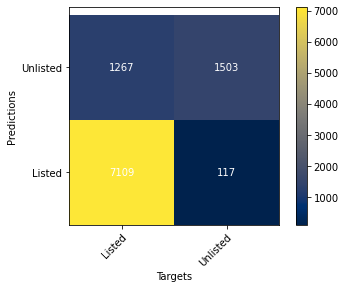



 Validation confusion matrix:


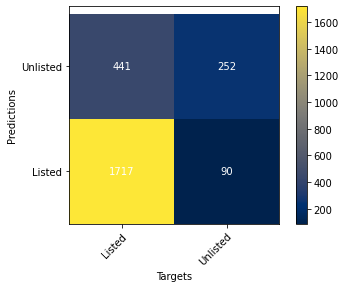


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       0.85      0.98      0.91      7226
           1       0.93      0.54      0.68      2770

    accuracy                           0.86      9996
   macro avg       0.89      0.76      0.80      9996
weighted avg       0.87      0.86      0.85      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.80      0.95      0.87      1807
           1       0.74      0.36      0.49       693

    accuracy                           0.79      2500
   macro avg       0.77      0.66      0.68      2500
weighted avg       0.78      0.79      0.76      2500



,train,val
metric,,
balanced_accuracy,0.763204,0.656915
precision,0.927778,0.736842
recall,0.542599,0.363636
f1,0.684738,0.486957
roc_auc,0.763204,0.656915


In [92]:
tf_idf(lr)

### Gaussian Naive Bayes

In [93]:
gnb = GaussianNB()

Training confusion matrix:


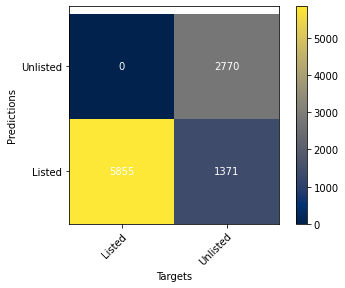



 Validation confusion matrix:


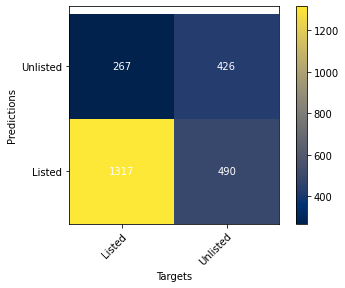


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      0.81      0.90      7226
           1       0.67      1.00      0.80      2770

    accuracy                           0.86      9996
   macro avg       0.83      0.91      0.85      9996
weighted avg       0.91      0.86      0.87      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.73      0.78      1807
           1       0.47      0.61      0.53       693

    accuracy                           0.70      2500
   macro avg       0.65      0.67      0.65      2500
weighted avg       0.73      0.70      0.71      2500



,train,val
metric,,
balanced_accuracy,0.905134,0.671775
precision,0.668921,0.465066
recall,1.000000,0.614719
f1,0.801621,0.529521
roc_auc,0.905134,0.671775


In [94]:
tf_idf(gnb)

### Balanced Random Forest

In [96]:
brf = BalancedRandomForestClassifier(random_state=42, n_jobs=2)

Training confusion matrix:


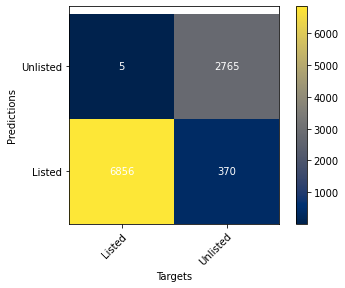



 Validation confusion matrix:


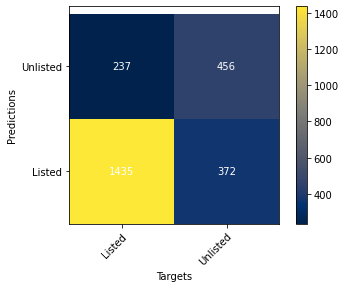


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      0.95      0.97      7226
           1       0.88      1.00      0.94      2770

    accuracy                           0.96      9996
   macro avg       0.94      0.97      0.95      9996
weighted avg       0.97      0.96      0.96      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.86      0.79      0.82      1807
           1       0.55      0.66      0.60       693

    accuracy                           0.76      2500
   macro avg       0.70      0.73      0.71      2500
weighted avg       0.77      0.76      0.76      2500



,train,val
metric,,
balanced_accuracy,0.973495,0.726071
precision,0.881978,0.550725
recall,0.998195,0.658009
f1,0.936494,0.599606
roc_auc,0.973495,0.726071


In [97]:
tf_idf(brf)

## TF-IDF with different ngrams

In [98]:
def tf_idf_difngram(model,class_report=True, plot_confusion_matrix=True):
    tfidf_f1score_df = pd.DataFrame()
    max_range_list = [1,2,3,4,5,6]

    for max_range in max_range_list:
        transformer = FeatureUnion([
                        ('host_about_tfidf', 
                          Pipeline([('extract_field',
                                      FunctionTransformer(lambda x: x['host_about'], 
                                                          validate=False)),
                                    ('tfidf', 
                                      TfidfVectorizer(ngram_range=(1,max_range)))])),
                        ('description_tfidf', 
                          Pipeline([('extract_field', 
                                      FunctionTransformer(lambda x: x['description'], 
                                                          validate=False)),
                                    ('tfidf', 
                                      TfidfVectorizer(ngram_range=(1,max_range)))]))]) 

        tfidf_airbnb_train = transformer.fit_transform(X_airbnb_train_clean)
        tfidf_airbnb_val = transformer.transform(X_airbnb_val_clean)
        df = apply_model(tfidf_airbnb_train, y_airbnb_train, tfidf_airbnb_val, y_airbnb_val, metrics=['f1'], model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
        tfidf_f1score_df = pd.concat([tfidf_f1score_df, df])
    tfidf_f1score_df['range'] = max_range_list
    return tfidf_f1score_df

In [99]:
tf_idf_difngram(modelknn, class_report=False, plot_confusion_matrix=False)

,train,val,range
metric,,,
f1,0.991676,0.591736,1
f1,0.991682,0.595258,2
f1,0.991688,0.584565,3
f1,0.991691,0.581967,4
f1,0.991676,0.587171,5
f1,0.991673,0.581549,6


In [160]:
tf_idf_difngram(mlp_55, class_report=False, plot_confusion_matrix=False)

,train,val,range
metric,,,
f1,0.980111,0.593272,1
f1,0.989892,0.615516,2
f1,0.991351,0.634271,3
f1,0.990404,0.618794,4
f1,0.985865,0.619792,5
f1,0.000000,0.000000,6


In [161]:
tf_idf_difngram(brf, class_report=False, plot_confusion_matrix=False)

,train,val,range
metric,,,
f1,0.936494,0.599606,1
f1,0.933558,0.600000,2
f1,0.937924,0.596606,3
f1,0.933716,0.591678,4
f1,0.933333,0.593548,5
f1,0.934684,0.588552,6


<a class="anchor" id="topic04.02" /><br>
## 4.2 TF-IDF with reviews

### Reviews as sentiment analysis

In [164]:
def tf_idf_sentiment(model, class_report=True, plot_confusion_matrix=True):
    transformer = FeatureUnion([
                    ('host_about_tfidf', 
                      Pipeline([('extract_field',
                                  FunctionTransformer(lambda x: x['host_about'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
                    ('description_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['description'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())]))]) 

    tfidf_airbnb_train = transformer.fit_transform(X_airbnb_train_clean)
    tfidf_array_train = tfidf_airbnb_train.toarray()
    tfidf_df_train = pd.DataFrame(tfidf_array_train, index=X_airbnb_train_clean.index)
    tfidf_df_train['sentiment'] = X_airbnb_train_clean_sent['sentiment']
    tfidf_with_sentiment_train = sparse.csr_matrix(tfidf_df_train.values)
    
    tfidf_airbnb_val = transformer.transform(X_airbnb_val_clean)
    tfidf_array_val = tfidf_airbnb_val.toarray()
    tfidf_df_val = pd.DataFrame(tfidf_array_val, index=X_airbnb_val_clean.index)
    tfidf_df_val['sentiment'] = X_airbnb_val_clean_sent['sentiment']
    tfidf_with_sentiment_val = sparse.csr_matrix(tfidf_df_val.values)
    

    if isinstance(model, GaussianNB):
        df = apply_model(X_train=tfidf_airbnb_train.toarray(),y_train=y_airbnb_train, X_val=tfidf_airbnb_val.toarray(), y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    else:
        df = apply_model(X_train=tfidf_with_sentiment_train,y_train=y_airbnb_train, X_val=tfidf_with_sentiment_val, y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    return df

Training confusion matrix:


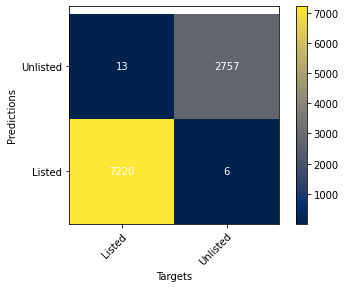



 Validation confusion matrix:


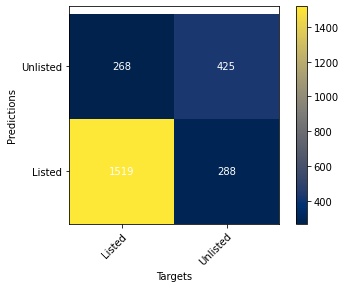


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.85      0.84      0.85      1807
           1       0.60      0.61      0.60       693

    accuracy                           0.78      2500
   macro avg       0.72      0.73      0.72      2500
weighted avg       0.78      0.78      0.78      2500



,train,val
metric,,
balanced_accuracy,0.997238,0.726948
precision,0.997828,0.596073
recall,0.995307,0.613276
f1,0.996566,0.604552
roc_auc,0.997238,0.726948


In [169]:
tf_idf_sentiment(modelknn,class_report=True, plot_confusion_matrix=True)

In [168]:
tf_idf_sentiment(brf,class_report=False, plot_confusion_matrix=False)

,train,val
metric,,
balanced_accuracy,0.980307,0.729408
precision,0.907571,0.499035
recall,0.999639,0.746032
f1,0.951383,0.598034
roc_auc,0.980307,0.729408


### Reviews as embeddings

In [104]:
reviews_train_sent = X_reviews_train_clean.groupby(['index'])['comments'].apply(' '.join)
reviews_val_sent = X_reviews_val_clean.groupby(['index'])['comments'].apply(' '.join)

In [105]:
X_concat_train = X_airbnb_train_clean.join(reviews_train_sent)
X_concat_val =  X_airbnb_val_clean.join(reviews_val_sent)

X_concat_train['comments'] = X_concat_train['comments'].fillna('')
X_concat_val['comments'] = X_concat_val['comments'].fillna('')

In [106]:
def tf_idf_all(model, class_report=True, plot_confusion_matrix=True):
    transformer = FeatureUnion([
                    ('host_about_tfidf', 
                      Pipeline([('extract_field',
                                  FunctionTransformer(lambda x: x['host_about'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
                    ('description_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['description'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
        
                    ('comments_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['comments'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
    ]) 

    tfidf_X_concat_train = transformer.fit_transform(X_concat_train)
    tfidf_X_concat_val = transformer.transform(X_concat_val)
    if isinstance(model, GaussianNB):
        df = apply_model(X_train=tfidf_X_concat_train.toarray(),y_train=y_airbnb_train, X_val=tfidf_X_concat_val.toarray(), y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    else:
        df = apply_model(X_train=tfidf_X_concat_train,y_train=y_airbnb_train, X_val=tfidf_X_concat_val, y_val=y_airbnb_val, metrics=['balanced_accuracy','precision','recall', 'f1','roc_auc' ],model = model, class_report=class_report, plot_confusion_matrix=plot_confusion_matrix)
    return df

Training confusion matrix:


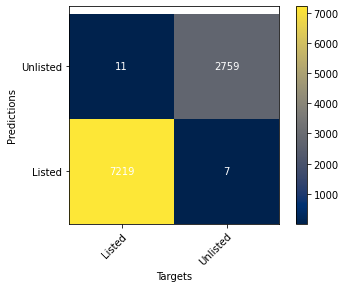



 Validation confusion matrix:


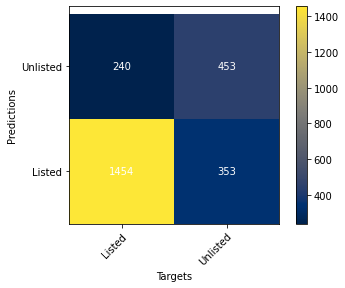


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.86      0.80      0.83      1807
           1       0.56      0.65      0.60       693

    accuracy                           0.76      2500
   macro avg       0.71      0.73      0.72      2500
weighted avg       0.78      0.76      0.77      2500



,train,val
metric,,
balanced_accuracy,0.997530,0.729164
precision,0.997469,0.562035
recall,0.996029,0.653680
f1,0.996749,0.604403
roc_auc,0.997530,0.729164


In [107]:
tf_idf_all(modelknn, class_report=True, plot_confusion_matrix=True)

<a class="anchor" id="topic05" /><br>
# Step 5: GloVe Embeddings
[Back to Index](#index)

<a class="anchor" id="topic05.01" /><br>
## 5.1 GloVe without reviews

#### Trying by generating embeddings for concatenated columns

In [108]:
tokenized_X_train_airbnb = tokenize(X_airbnb_train_clean, columns=text_columns_airbnb)
tokenized_X_val_airbnb = tokenize(X_airbnb_val_clean, columns=text_columns_airbnb)

In [109]:
vocab_dim = 300

In [110]:
glove = vocab.GloVe(name='6B', dim=vocab_dim)

In [111]:
def get_word(word):
    try:
        return glove.vectors[glove.stoi[word]]
    except:
        return torch.zeros(vocab_dim)

    
def get_embed(tokens):
    if len(tokens) == 0:
        embedding = torch.zeros(vocab_dim)
    else:
        sentence_embedding = list(map(lambda x: get_word(x), tokens))
        embedding = torch.mean(torch.stack(sentence_embedding), dim=0)
    return embedding

In [112]:
tokenized_X_train_airbnb['host_and_description']  = tokenized_X_train_airbnb['host_about'] + tokenized_X_train_airbnb['description']
tokenized_X_val_airbnb['host_and_description']  = tokenized_X_val_airbnb['host_about']  + tokenized_X_val_airbnb['description']

In [113]:
def GloVe_emb(model, plot_confusion_matrix=True, class_report=True):
    X_airbnb_train_glove =  tokenized_X_train_airbnb['host_and_description'].apply(lambda x: get_embed(x).numpy()).tolist()
    X_airbnb_val_glove =  tokenized_X_val_airbnb['host_and_description'].apply(lambda x: get_embed(x).numpy()).tolist()
    
    return apply_model(X_train = X_airbnb_train_glove, y_train=y_airbnb_train, X_val= X_airbnb_val_glove, y_val=y_airbnb_val, model = model, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=plot_confusion_matrix, class_report=plot_confusion_matrix)

Training confusion matrix:


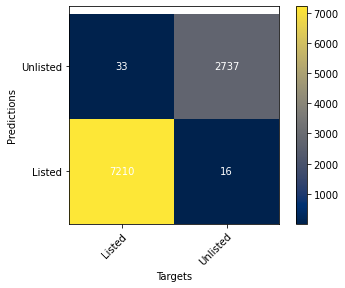



 Validation confusion matrix:


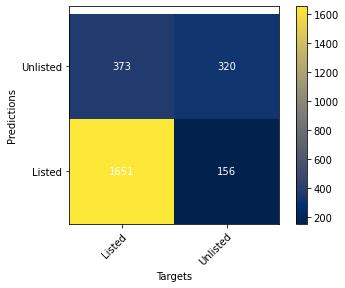


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       0.99      0.99      0.99      2770

    accuracy                           1.00      9996
   macro avg       0.99      0.99      0.99      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.82      0.91      0.86      1807
           1       0.67      0.46      0.55       693

    accuracy                           0.79      2500
   macro avg       0.74      0.69      0.70      2500
weighted avg       0.78      0.79      0.77      2500



,train,val
metric,,
balanced_accuracy,0.992936,0.687715
f1,0.991128,0.547476
recall,0.988087,0.461760
precision,0.994188,0.672269
roc_auc,0.992936,0.687715


In [114]:
GloVe_emb(modelknn, plot_confusion_matrix=True, class_report=True)

#### Trying by generating embeddings for each column and then joining them

Training confusion matrix:


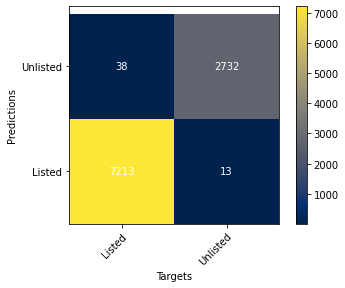



 Validation confusion matrix:


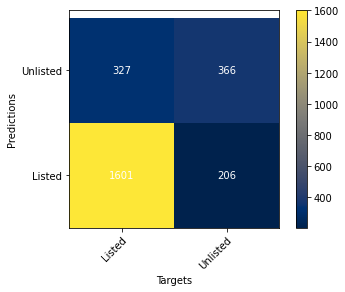


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       0.99      1.00      1.00      7226
           1       1.00      0.99      0.99      2770

    accuracy                           0.99      9996
   macro avg       1.00      0.99      0.99      9996
weighted avg       0.99      0.99      0.99      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.89      0.86      1807
           1       0.64      0.53      0.58       693

    accuracy                           0.79      2500
   macro avg       0.74      0.71      0.72      2500
weighted avg       0.78      0.79      0.78      2500



,train,val
metric,,
balanced_accuracy,0.992241,0.707069
f1,0.990752,0.578656
recall,0.986282,0.528139
precision,0.995264,0.639860
roc_auc,0.992241,0.707069


In [115]:
X_airbnb_train_glove_df = pd.DataFrame()
X_airbnb_val_glove_df = pd.DataFrame()
X_airbnb_train_glove_df['host_about']=  tokenized_X_train_airbnb['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_train_glove_df['description'] =  tokenized_X_train_airbnb['description'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['host_about'] =  tokenized_X_val_airbnb['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['description'] =  tokenized_X_val_airbnb['description'].apply(lambda x: get_embed(x).numpy())

X_airbnb_train_glove_df = X_airbnb_train_glove_df.apply(
    lambda row: np.concatenate((row['host_about'], row['description'])), axis=1
).tolist()
X_airbnb_val_glove_df = X_airbnb_val_glove_df.apply(
    lambda row: np.concatenate((row['host_about'], row['description'])), axis=1
).tolist()
apply_model(X_train = X_airbnb_train_glove_df, y_train=y_airbnb_train, X_val= X_airbnb_val_glove_df, y_val=y_airbnb_val, model = modelknn, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=True, class_report=True)

#### Trying by generating embeddings for each column and then averaging them

Training confusion matrix:


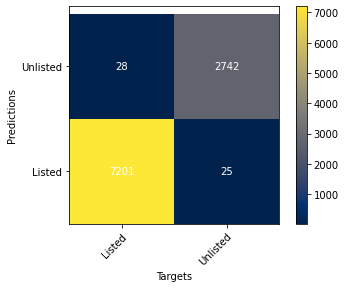



 Validation confusion matrix:


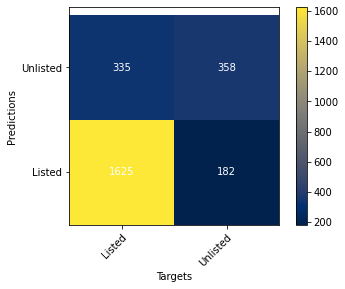


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       0.99      0.99      0.99      2770

    accuracy                           0.99      9996
   macro avg       0.99      0.99      0.99      9996
weighted avg       0.99      0.99      0.99      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.90      0.86      1807
           1       0.66      0.52      0.58       693

    accuracy                           0.79      2500
   macro avg       0.75      0.71      0.72      2500
weighted avg       0.78      0.79      0.78      2500



,train,val
metric,,
balanced_accuracy,0.993216,0.707938
f1,0.990428,0.580697
recall,0.989892,0.516595
precision,0.990965,0.662963
roc_auc,0.993216,0.707938


In [116]:
X_airbnb_train_glove_df = pd.DataFrame()
X_airbnb_val_glove_df = pd.DataFrame()
X_airbnb_train_glove_df['host_about'] = tokenized_X_train_airbnb['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_train_glove_df['description'] = tokenized_X_train_airbnb['description'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['host_about'] = tokenized_X_val_airbnb['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['description'] = tokenized_X_val_airbnb['description'].apply(lambda x: get_embed(x).numpy())

X_airbnb_train_glove_df['mean_embedding'] = X_airbnb_train_glove_df[['host_about', 'description']].apply(lambda row: np.mean(row), axis=1)
X_airbnb_val_glove_df['mean_embedding'] = X_airbnb_val_glove_df[['host_about', 'description']].apply(lambda row: np.mean(row), axis=1)

X_airbnb_train_glove_df = X_airbnb_train_glove_df['mean_embedding'].tolist()
X_airbnb_val_glove_df = X_airbnb_val_glove_df['mean_embedding'].tolist()

apply_model(X_train=X_airbnb_train_glove_df, y_train=y_airbnb_train, X_val=X_airbnb_val_glove_df, y_val=y_airbnb_val, model=modelknn, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=True, class_report=True)

<a class="anchor" id="topic05.02" /><br>
## 5.2 GloVe with reviews

### Reviews as sentiment analysis
#### Trying by generating embeddings for concatenated columns

In [137]:
def GloVe_emb_together_sent(model, plot_confusion_matrix=True, class_report=True):
    X_airbnb_train_glove =  tokenized_X_train_airbnb['host_and_description'].apply(lambda x: get_embed(x).numpy()).tolist()
    X_airbnb_val_glove =  tokenized_X_val_airbnb['host_and_description'].apply(lambda x: get_embed(x).numpy()).tolist()
    
    j=0
    for i in X_airbnb_train_clean_sent.index.tolist():
        # Get the sentiment value for the current array
        sentiment_train = X_airbnb_train_clean_sent['sentiment'][i]
        # Append the sentiment value to the end of the array
        X_airbnb_train_glove[j] = np.append(X_airbnb_train_glove[j], sentiment_train)
        j+=1
        
    j=0
    for i in X_airbnb_val_clean_sent.index.tolist():
        # Get the sentiment value for the current array
        sentiment_val = X_airbnb_val_clean_sent['sentiment'][i]
        # Append the sentiment value to the end of the array
        X_airbnb_val_glove[j] = np.append(X_airbnb_val_glove[j], sentiment_val)
        j+=1
        
    return apply_model(X_train = X_airbnb_train_glove, y_train=y_airbnb_train, X_val= X_airbnb_val_glove, y_val=y_airbnb_val, model = model, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=plot_confusion_matrix, class_report=plot_confusion_matrix)

Training confusion matrix:


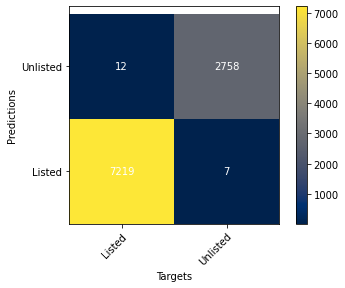



 Validation confusion matrix:


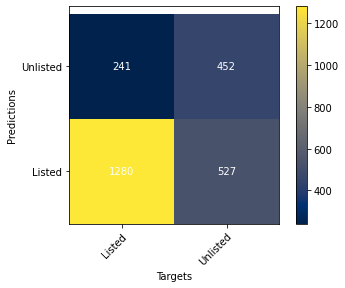


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.84      0.71      0.77      1807
           1       0.46      0.65      0.54       693

    accuracy                           0.69      2500
   macro avg       0.65      0.68      0.65      2500
weighted avg       0.74      0.69      0.71      2500



,train,val
metric,,
balanced_accuracy,0.997350,0.680297
f1,0.996567,0.540670
recall,0.995668,0.652237
precision,0.997468,0.461696
roc_auc,0.997350,0.680297


In [138]:
GloVe_emb_together_sent(modelknn, plot_confusion_matrix=True, class_report=True)

### Reviews as embeddings
#### Trying by generating embeddings for concatenated columns

In [139]:
X_concat_lang_train = X_concat_train.copy()
X_concat_lang_val = X_concat_val.copy()
X_concat_lang_train['comments_lang'] = pd.Series(dtype='str')
X_concat_lang_val['comments_lang'] = pd.Series(dtype='str')
X_concat_lang_train['comments_lang'] = X_concat_lang_train['comments_lang'].fillna('')
X_concat_lang_val['comments_lang'] = X_concat_lang_val['comments_lang'].fillna('')

In [140]:
tokenized_X_concat_train = tokenize(X_concat_lang_train, columns=text_columns_airbnb+text_columns_reviews)
tokenized_X_concat_val = tokenize(X_concat_lang_val, columns=text_columns_airbnb+text_columns_reviews)

In [141]:
tokenized_X_concat_train['host_and_description_com']  = tokenized_X_concat_train['host_about'] + tokenized_X_concat_train['description'] + tokenized_X_concat_train['comments']
tokenized_X_concat_val['host_and_description_com']  = tokenized_X_concat_val['host_about']  + tokenized_X_concat_val['description'] + tokenized_X_concat_val['comments']

In [142]:
def GloVe_emb_all(model, plot_confusion_matrix=True, class_report=True):
    X_airbnb_train_glove =  tokenized_X_concat_train['host_and_description_com'].apply(lambda x: get_embed(x).numpy()).tolist()
    X_airbnb_val_glove =  tokenized_X_concat_val['host_and_description_com'].apply(lambda x: get_embed(x).numpy()).tolist()
    
    return apply_model(X_train = X_airbnb_train_glove, y_train=y_airbnb_train, X_val= X_airbnb_val_glove, y_val=y_airbnb_val, model = model, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=plot_confusion_matrix, class_report=plot_confusion_matrix)

Training confusion matrix:


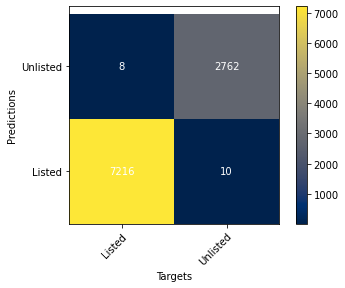



 Validation confusion matrix:


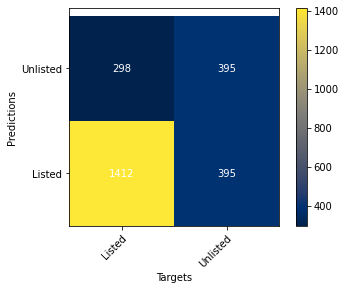


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.83      0.78      0.80      1807
           1       0.50      0.57      0.53       693

    accuracy                           0.72      2500
   macro avg       0.66      0.68      0.67      2500
weighted avg       0.74      0.72      0.73      2500



,train,val
metric,,
balanced_accuracy,0.997864,0.675696
f1,0.996752,0.532704
recall,0.997112,0.569986
precision,0.996392,0.500000
roc_auc,0.997864,0.675696


In [143]:
GloVe_emb_all(modelknn, plot_confusion_matrix=True, class_report=True)

#### Trying by generating embeddings for each column and then averaging them

Training confusion matrix:


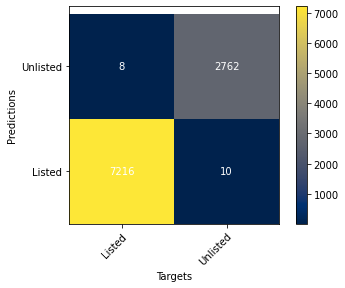



 Validation confusion matrix:


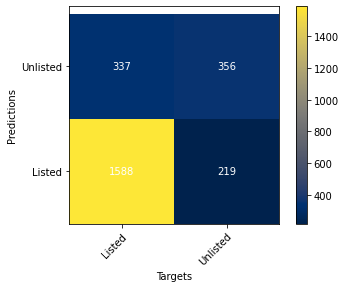


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       1.00      1.00      1.00      2770

    accuracy                           1.00      9996
   macro avg       1.00      1.00      1.00      9996
weighted avg       1.00      1.00      1.00      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.82      0.88      0.85      1807
           1       0.62      0.51      0.56       693

    accuracy                           0.78      2500
   macro avg       0.72      0.70      0.71      2500
weighted avg       0.77      0.78      0.77      2500



,train,val
metric,,
balanced_accuracy,0.997864,0.696257
f1,0.996752,0.561514
recall,0.997112,0.513709
precision,0.996392,0.619130
roc_auc,0.997864,0.696257


In [144]:
X_airbnb_train_glove_df = pd.DataFrame()
X_airbnb_val_glove_df = pd.DataFrame()
X_airbnb_train_glove_df['host_about'] = tokenized_X_concat_train['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_train_glove_df['description'] = tokenized_X_concat_train['description'].apply(lambda x: get_embed(x).numpy())
X_airbnb_train_glove_df['comments'] = tokenized_X_concat_train['comments'].apply(lambda x: get_embed(x).numpy())

X_airbnb_val_glove_df['host_about'] = tokenized_X_concat_val['host_about'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['description'] = tokenized_X_concat_val['description'].apply(lambda x: get_embed(x).numpy())
X_airbnb_val_glove_df['comments'] = tokenized_X_concat_val['comments'].apply(lambda x: get_embed(x).numpy())

X_airbnb_train_glove_df['mean_embedding'] = X_airbnb_train_glove_df[['host_about', 'description', 'comments']].apply(lambda row: np.mean(row), axis=1)
X_airbnb_val_glove_df['mean_embedding'] = X_airbnb_val_glove_df[['host_about', 'description', 'comments']].apply(lambda row: np.mean(row), axis=1)

X_airbnb_train_glove_df = X_airbnb_train_glove_df['mean_embedding'].tolist()
X_airbnb_val_glove_df = X_airbnb_val_glove_df['mean_embedding'].tolist()

apply_model(X_train=X_airbnb_train_glove_df, y_train=y_airbnb_train, X_val=X_airbnb_val_glove_df, y_val=y_airbnb_val, model=modelknn, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=True, class_report=True)

<a class="anchor" id="topic06" /><br>
# Step 6: FastText Embeddings
[Back to Index](#index)

<a class="anchor" id="topic06.01" /><br>
## 6.1 FastText without reviews

#### Trying by generating embeddings for concatenated columns

In [145]:
w2v = gensim.downloader.load('fasttext-wiki-news-subwords-300')

In [146]:
def get_word_ft(word):
    try:
        return torch.tensor(w2v[word])
    except:
        return torch.zeros(vocab_dim)


def get_embed_ft(tokens):
    if len(tokens) == 0:
        embedding = torch.zeros(vocab_dim)
    else:
        sentence_embedding = list(map(lambda x: get_word_ft(x), tokens))
        embedding = torch.mean(torch.stack(sentence_embedding), dim=0)
    return embedding

Training confusion matrix:


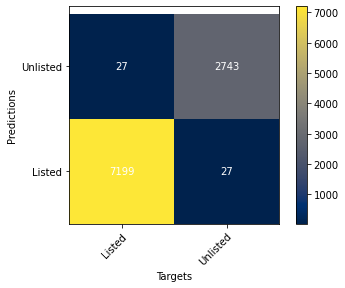



 Validation confusion matrix:


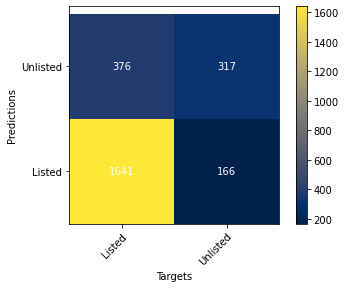


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      7226
           1       0.99      0.99      0.99      2770

    accuracy                           0.99      9996
   macro avg       0.99      0.99      0.99      9996
weighted avg       0.99      0.99      0.99      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.81      0.91      0.86      1807
           1       0.66      0.46      0.54       693

    accuracy                           0.78      2500
   macro avg       0.73      0.68      0.70      2500
weighted avg       0.77      0.78      0.77      2500



,train,val
metric,,
balanced_accuracy,0.993258,0.682783
f1,0.990253,0.539116
recall,0.990253,0.457431
precision,0.990253,0.656315
roc_auc,0.993258,0.682783


In [147]:
X_airbnb_train_ft =  tokenized_X_train_airbnb['host_and_description'].apply(lambda x: get_embed_ft(x).numpy()).tolist()
X_airbnb_val_ft =  tokenized_X_val_airbnb['host_and_description'].apply(lambda x: get_embed_ft(x).numpy()).tolist()
apply_model(X_train = X_airbnb_train_ft, y_train=y_airbnb_train, X_val= X_airbnb_val_ft, y_val=y_airbnb_val, model = modelknn, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=True, class_report=True)

#### Trying by generating embeddings for each column and then averaging them

Training confusion matrix:


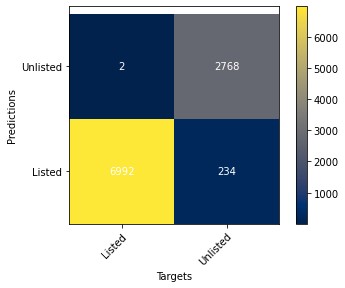



 Validation confusion matrix:


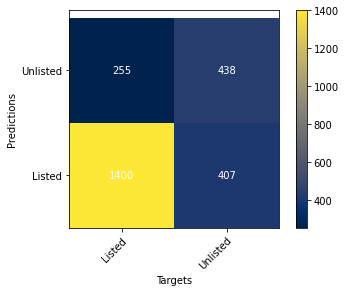


-------------------------------------------------------------

Training classification report:
              precision    recall  f1-score   support

           0       1.00      0.97      0.98      7226
           1       0.92      1.00      0.96      2770

    accuracy                           0.98      9996
   macro avg       0.96      0.98      0.97      9996
weighted avg       0.98      0.98      0.98      9996



Validation classification report:
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1807
           1       0.52      0.63      0.57       693

    accuracy                           0.74      2500
   macro avg       0.68      0.70      0.69      2500
weighted avg       0.76      0.74      0.74      2500



,train,val
metric,,
balanced_accuracy,0.983447,0.703400
f1,0.959113,0.569571
recall,0.999278,0.632035
precision,0.922052,0.518343
roc_auc,0.983447,0.703400


In [166]:
X_airbnb_train_ft_df = pd.DataFrame()
X_airbnb_val_ft_df = pd.DataFrame()
X_airbnb_train_ft_df['host_about'] = tokenized_X_train_airbnb['host_about'].apply(lambda x: get_embed_ft(x).numpy())
X_airbnb_train_ft_df['description'] = tokenized_X_train_airbnb['description'].apply(lambda x: get_embed_ft(x).numpy())
X_airbnb_val_ft_df['host_about'] = tokenized_X_val_airbnb['host_about'].apply(lambda x: get_embed_ft(x).numpy())
X_airbnb_val_ft_df['description'] = tokenized_X_val_airbnb['description'].apply(lambda x: get_embed_ft(x).numpy())

X_airbnb_train_ft_df['mean_embedding'] = X_airbnb_train_ft_df[['host_about', 'description']].apply(lambda row: np.mean(row), axis=1)
X_airbnb_val_ft_df['mean_embedding'] = X_airbnb_val_ft_df[['host_about', 'description']].apply(lambda row: np.mean(row), axis=1)

X_airbnb_train_ft_df = X_airbnb_train_ft_df['mean_embedding'].tolist()
X_airbnb_val_ft_df = X_airbnb_val_ft_df['mean_embedding'].tolist()

apply_model(X_train=X_airbnb_train_ft_df, y_train=y_airbnb_train, X_val=X_airbnb_val_ft_df, y_val=y_airbnb_val, model=brf, metrics=["balanced_accuracy", "f1", "recall", "precision", "roc_auc"], plot_confusion_matrix=True, class_report=True)

<a class="anchor" id="topic07" /><br>
# Step 7: Test predictions
[Back to Index](#index)

In [ ]:
X_airbnb_train, X_airbnb_val, y_airbnb_train, y_airbnb_val = train_test_split(airbnb_df_train.drop(['unlisted'], axis=1),
                                                                              airbnb_df_train['unlisted'],
                                                                              test_size=0.2, 
                                                                              train_size=0.8,
                                                                              random_state=42,
                                                                              shuffle=True,
                                                                              stratify=airbnb_df_train['unlisted'])

In [ ]:
# applying the preprocessing to the training dataset

X_airbnb_train_clean = pipelinefunc(X_airbnb_train,
             columns = text_columns_airbnb,
             conv_emoji=False
             )
X_airbnb_train_clean.fillna('', inplace=True)

X_airbnb_train_clean.set_index('index', inplace=True)

X_reviews_train = reviews_df_train[reviews_df_train['index'].isin(X_airbnb_train.index)]
X_reviews_train.reset_index(drop=True, inplace=True)

X_reviews_train_clean =  pipelinefunc(X_reviews_train,
             columns = text_columns_reviews,
             removeemoji=False
             )
X_reviews_train_clean.fillna('', inplace=True)

X_reviews_train_clean['comments'] = X_reviews_train_clean['comments'].astype('str')

reviews_sentiment_train = sentiment_reviews(X_reviews_train_clean,columns=text_columns_reviews)

reviews_sentiment_train_byIndex = reviews_sentiment_train.groupby('index', as_index=True)['sentiment'].mean()
X_airbnb_train_clean_sent = X_airbnb_train_clean.join(reviews_sentiment_train_byIndex.rename('sentiment'))
X_airbnb_train_clean_sent['sentiment'] = X_airbnb_train_clean_sent['sentiment'].fillna(0)

In [20]:
# applying the preprocessing to the test dataset

X_airbnb_test_clean =  pipelinefunc(airbnb_df_test,
             columns = text_columns_airbnb,
             conv_emoji=False
             )
X_airbnb_test_clean.fillna('', inplace=True)

print('Airbnb Test Cleaned')

X_reviews_test_clean =  pipelinefunc(reviews_df_test,
             columns = text_columns_reviews,
             removeemoji=False
             )
X_reviews_test_clean.fillna('', inplace=True)

print('Airbnb Reviews Cleaned')

X_reviews_test_clean['comments'] = X_reviews_test_clean['comments'].astype('str')

reviews_sentiment_test = sentiment_reviews(X_reviews_test_clean,columns=text_columns_reviews)

reviews_sentiment_test_byIndex = reviews_sentiment_test.groupby('index', as_index=True)['sentiment'].mean()

X_airbnb_test_clean_sent = X_airbnb_test_clean.join(reviews_sentiment_test_byIndex.rename('sentiment'))
X_airbnb_test_clean_sent['sentiment'] = X_airbnb_test_clean_sent['sentiment'].fillna(0)

html done
lowercase done
contraction done
punctuation done
remove_emoji done
detect_language done
digits done
stopwords done
lematize done
Airbnb Test Cleaned
html done
lowercase done
contraction done
punctuation done
detect_language done
conv_emoji done
punctuation 2 done
digits done
stopwords done
lematize done
Airbnb Reviews Cleaned


Sentiment Analysis of comments: 100%|██████████| 80877/80877 [03:22<00:00, 399.47it/s] 


In [23]:
# function to generate predictions

def tf_idf_sentiment_test_predicitons(model, class_report=True, plot_confusion_matrix=True, vprint=False):
    transformer = FeatureUnion([
                    ('host_about_tfidf', 
                      Pipeline([('extract_field',
                                  FunctionTransformer(lambda x: x['host_about'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())])),
                    ('description_tfidf', 
                      Pipeline([('extract_field', 
                                  FunctionTransformer(lambda x: x['description'], 
                                                      validate=False)),
                                ('tfidf', 
                                  TfidfVectorizer())]))]) 

    tfidf_airbnb_train = transformer.fit_transform(X_airbnb_train_clean)
    tfidf_array_train = tfidf_airbnb_train.toarray()
    tfidf_df_train = pd.DataFrame(tfidf_array_train, index=X_airbnb_train_clean.index)
    tfidf_df_train['sentiment'] = X_airbnb_train_clean_sent['sentiment']
    tfidf_with_sentiment_train = sparse.csr_matrix(tfidf_df_train.values)
    
    tfidf_airbnb_test = transformer.transform(X_airbnb_test_clean)
    tfidf_array_test = tfidf_airbnb_test.toarray()
    tfidf_df_test = pd.DataFrame(tfidf_array_test, index=X_airbnb_test_clean.index)
    tfidf_df_test['sentiment'] = X_airbnb_test_clean_sent['sentiment']
    tfidf_with_sentiment_test = sparse.csr_matrix(tfidf_df_test.values)


    model_fitted = model.fit(tfidf_with_sentiment_train, y_airbnb_train)
    y_test_pred = model_fitted.predict(tfidf_with_sentiment_test)

    return y_test_pred


In [32]:
predictions = tf_idf_sentiment_test_predicitons(modelknn)

In [43]:
pd.DataFrame(predictions).to_csv('Predictions_15.csv')